# Idea
Do some feature ranking. 

**BUT**: SYSTE needs addional feature engineering.

**REMARKS**: addional parameter to show which version of system (0:old-simple bow; 1: process-syscall info; 2: 2-gram)

| **Possible DataSources** |
| --- |
| SYS_data |
| KERN_data |
| FLS_data |
| RES_data |
| block_data |
| network_data |
| entropy_data |


In [1]:
DATA_SOURCE = "SYS_data"
DEVICE_SOURCE = "Heqing_device2"

In [2]:
from enum import Enum

class SystemVersion(Enum):
    OLD_BOW = 'old-bow'
    PROCESS_INFO = 'process_info'
    TWO_GRAM = '2-gram'

VERSION = SystemVersion.TWO_GRAM

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

In [4]:
import sys
repo_base_path = Path("./../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))

from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting
from py_dataset import feature_selection

from py_dataset import sys_func
# from py_dataset import net_feature_engineering

# Loading Sys Data

##### 1. normal: bow

In [5]:
if VERSION != SystemVersion.OLD_BOW:
    raise NotImplementedError("Only OLD_BOW is implemented")


file_path = Path('/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/merged_data.npz')
assert file_path.exists(), 'Data not found'

with np.load(file_path, allow_pickle=True) as npz:
    print(npz.files)
    X = npz['arr_0']
print(X.shape)

vectorizer = sys_func.create_CountVectorizer()
cols = vectorizer.get_feature_names_out()
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(X, columns=cols)
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

vectors = df.copy()
print(vectors.shape)
vectors.head(1)

NotImplementedError: Only OLD_BOW is implemented

##### 2. using process-sys_call information

In [6]:
if VERSION != SystemVersion.PROCESS_INFO:
    raise NotImplementedError("Only PROCESS_INFO is Run here")


from scipy.sparse import csr_matrix, vstack, hstack, save_npz, load_npz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pickle
from sklearn.feature_selection import mutual_info_classif


data_path = Path(
    '/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/advanced')
assert data_path.exists()

def load_and_combine_npz_sparse(path):
    output_array = None

    for npz_file in path.glob("*.npz"):
        sparse_array = load_npz(npz_file)

        if output_array is None:
            output_array = sparse_array
        else:
            output_array = vstack((output_array, sparse_array))

    return output_array

path_to_read = data_path / 'merged_data_big_dataset'

merged = load_and_combine_npz_sparse(path_to_read)

vocab_file = data_path / "vocabulary_topK.pkl" #int(system_calls["calls"]) > 5 and float(process["cpu_usage"]) > 0 ==> 27GB and len 157711


if vocab_file.exists():
    with open(str(vocab_file), 'rb') as f:
        vocabulary = pickle.load(f)
    print("Loaded vocab:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)

X = merged[:, :-2]
Z = merged[:, -2:]

transformer = TfidfTransformer()
X_tf = transformer.fit_transform(X)
cols = vectorizer.get_feature_names_out()
label_encoder = sys_func.create_label_encoder_for_labels()

assert Z[:,-2:].shape[0] >0

# vectors = hstack((X_tf, Z[:,-2:])) # add the labels => maybe runs out of memory => if so (maybe use low_variance before)


# vectors_dense = vectors.toarray()

cols_X = vectorizer.get_feature_names_out()
# cols = np.append(cols, [['timestamp'], ['label']])
print (cols_X.shape)
df = pd.DataFrame(Z.toarray(), columns=['timestamp', 'label'])
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

# vectors = df.copy()
# print(vectors.shape)
# vectors.head(1)

df.head(1)

NotImplementedError: Only PROCESS_INFO is Run here

##### 3. using 2-grams of sys-calls

In [7]:
if VERSION != SystemVersion.TWO_GRAM:
    raise NotImplementedError("Only TWO_GRAM is Run here")


from sklearn.feature_extraction.text import CountVectorizer
import pickle

file_path = Path('/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/merged_data_ngrams.npz')
assert file_path.exists(), 'Data not found'

data_path = Path(
    "/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/"
)
assert data_path.exists()
vocab_file = data_path / "vocabulary_ngrams.pkl"

if vocab_file.exists():
    with open(str(vocab_file), "rb") as f:
        vocabulary = pickle.load(f)

    print("Loaded set:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)

with np.load(file_path, allow_pickle=True) as npz:
    print(npz.files)
    X = npz['arr_0']
print(X.shape)

cols = vectorizer.get_feature_names_out()
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(X, columns=cols)
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

vectors = df.copy()
print(vectors.shape)
vectors.head(1)

Loaded set: ('accept', 'accept4', 'access', 'add_key', 'adjtimex', 'bind', 'brk', 'capget', 'capset', 'chdir', 'chmod', 'chown32', 'clock_gettime', 'clone', 'close', 'connect', 'dup', 'dup2', 'dup3', 'epoll_create1', 'epoll_ctl', 'epoll_wait', 'eventfd2', 'execve', 'exit', 'exit_group', 'faccessat', 'fadvise64_64', 'fallocate', 'fchdir', 'fchmod', 'fchmodat', 'fchown32', 'fcntl64', 'fgetxattr', 'flistxattr', 'flock', 'fsetxattr', 'fstat64', 'fstatat64', 'fstatfs64', 'fsync', 'ftruncate64', 'futex', 'getcwd', 'getdents64', 'getegid32', 'geteuid32', 'getgid32', 'getgroups32', 'getpeername', 'getpgid', 'getpgrp', 'getpid', 'getppid', 'getpriority', 'getrandom', 'getresgid32', 'getresuid32', 'getsid', 'getsockname', 'getsockopt', 'gettid', 'gettimeofday', 'getuid32', 'getxattr', 'inotify_add_watch', 'ioctl', 'ioprio_get', 'ioprio_set', 'kcmp', 'keyctl', 'kill', 'lchown32', 'lgetxattr', 'llseek', 'lseek', 'lstat64', 'madvise', 'mkdir', 'mknod', 'mmap2', 'mount', 'mprotect', 'mremap', 'msync

,accept,accept4,access,add_key,adjtimex,bind,brk,capget,capset,chdir,...,utimensat waitid,utimensat write,utimensat writev,wait4 waitid,wait4 write,wait4 writev,waitid write,waitid writev,write writev,label
timestamp,,,,,,,,,,,,,,,,,,,,,
1.699632e+09,0.0,0.000024,0.000491,0.0,0.0,0.000005,0.000605,0.000017,0.0,0.000006,...,0.0,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,0.0,4_bashlite


#### Preprocessing

Max values for each column: [1.41066354e-04 9.39362725e-04 4.29246599e-02 ... 8.33483924e-05
 1.69984122e+09 8.00000000e+00]
Min values for each column: [8.09355319e-06 2.00943634e-06 1.91403504e-04 ... 1.48869813e-05
 1.69954312e+09 1.00000000e+00]


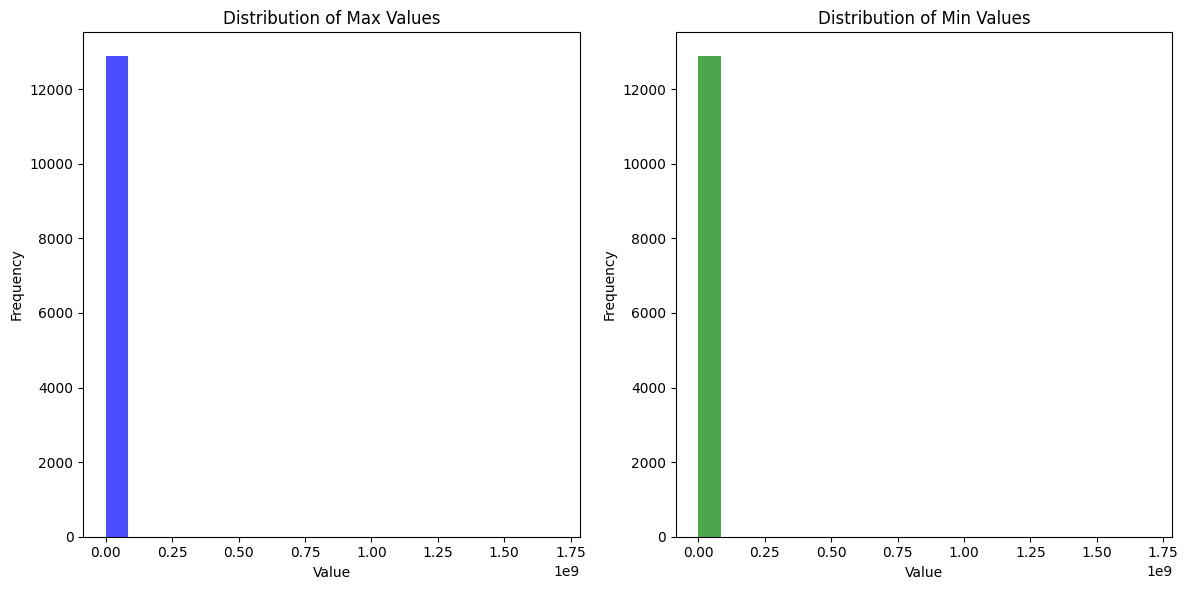

In [9]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

sparse_matrix = sp.csr_matrix(X)
# Convert to CSC format for efficient column operations
sparse_matrix_csc = sparse_matrix.tocsc()

# Initialize arrays to hold max and min values
max_values = np.zeros(sparse_matrix.shape[1])
min_values = np.zeros(sparse_matrix.shape[1])

# Iterate through each column
for i in range(sparse_matrix.shape[1]):
    column = sparse_matrix_csc.getcol(i).data  # Extract the column data
    if column.size > 0:
        max_values[i] = column.max()
        min_values[i] = column.min()
    else:
        max_values[i] = 0  # or np.nan if you prefer to indicate no data
        min_values[i] = 0  # or np.nan

print("Max values for each column:", max_values)
print("Min values for each column:", min_values)

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(max_values, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Max Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(min_values, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Min Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [11]:
vectors.reset_index(inplace=True, drop=True)  # drops: "timestamp"

cols_to_exclude_from_scaling = ["label"]

vectors = feature_plotting.test_transform_all_to_numeric_columns(vectors, cols_to_exclude_from_scaling)
vectors_scaled = feature_plotting.minmax_scale_features(vectors,
                                                        remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

# vectors_robust_scaled = feature_plotting.minmax_scale_features(vectors,
#                                                                remove_outliers_iqr_all_columns=True,
#                                                                cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

ValueError: Found array with 0 sample(s) (shape=(0, 12880)) while a minimum of 1 is required.

In [17]:
X = vectors_scaled.drop(columns=["label"])
Y = vectors_scaled["label"]

assert X.dropna().shape == X.shape, "X contains NaNs"

#### Ranking

In [21]:
d = feature_selection.get_low_variance_features(X, threshold=0.0)
print(len(d),d)

8229 ['nan', 'accept accept4', 'accept access', 'accept add_key', 'accept adjtimex', 'accept bind', 'accept brk', 'accept capget', 'accept capset', 'accept chdir', 'accept chmod', 'accept chown32', 'accept clone', 'accept close', 'accept connect', 'accept dup', 'accept dup2', 'accept dup3', 'accept epoll_create1', 'accept epoll_ctl', 'accept epoll_wait', 'accept eventfd2', 'accept execve', 'accept exit', 'accept exit_group', 'accept faccessat', 'accept fadvise64_64', 'accept fallocate', 'accept fchdir', 'accept fchmod', 'accept fchmodat', 'accept fchown32', 'accept fgetxattr', 'accept flistxattr', 'accept flock', 'accept fsetxattr', 'accept fstatat64', 'accept fstatfs64', 'accept fsync', 'accept ftruncate64', 'accept getcwd', 'accept getdents64', 'accept getegid32', 'accept geteuid32', 'accept getgid32', 'accept getgroups32', 'accept getpeername', 'accept getpgid', 'accept getpgrp', 'accept getppid', 'accept getpriority', 'accept getrandom', 'accept getresgid32', 'accept getresuid32', 

In [22]:
X.drop(columns=feature_selection.get_low_variance_features(X, threshold=0.0), inplace=True)


In [23]:
scores_by_label = feature_selection.calculate_scores_by_label(X, Y)
scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()
singles = scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()

Label: 4_bashlite
Label: 7_backdoor
Label: 5_httpbackdoor
Label: 2_ransomware
Label: 6_beurk
Label: 3_thetick
Label: 8_bdvl
Label: 1_normal
Label: 9_xmrig


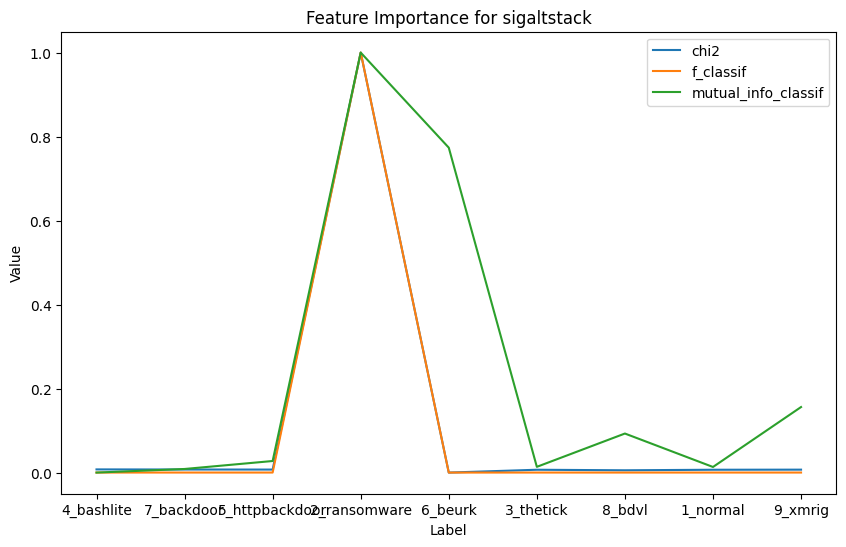

In [24]:
test_df = scores_by_label.copy()
feature_selection.sort_by_mean(test_df)
test_df.reset_index(inplace=True)
best_Feature = test_df.loc[0]["feature"]

feature_selection.plot_scores_by_label_single_plot_single_feature( scores_by_label, best_Feature)

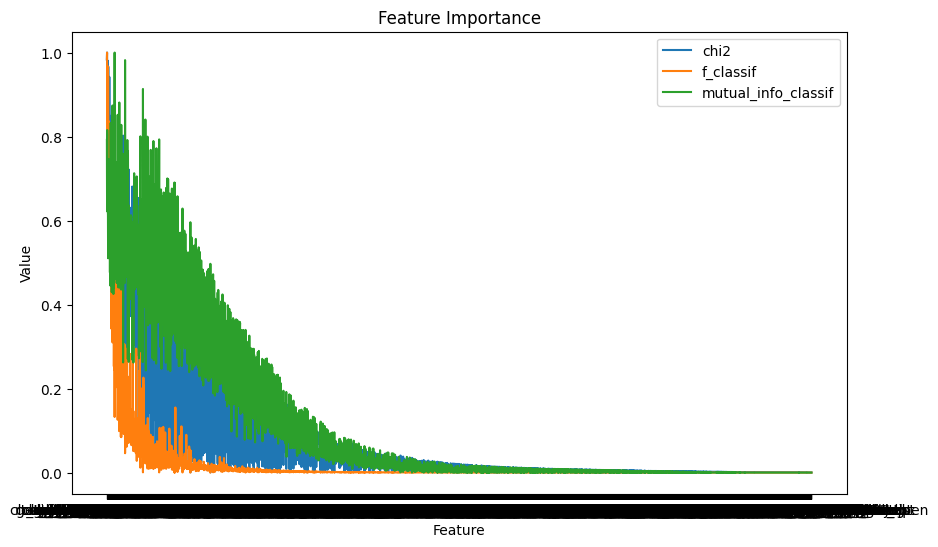

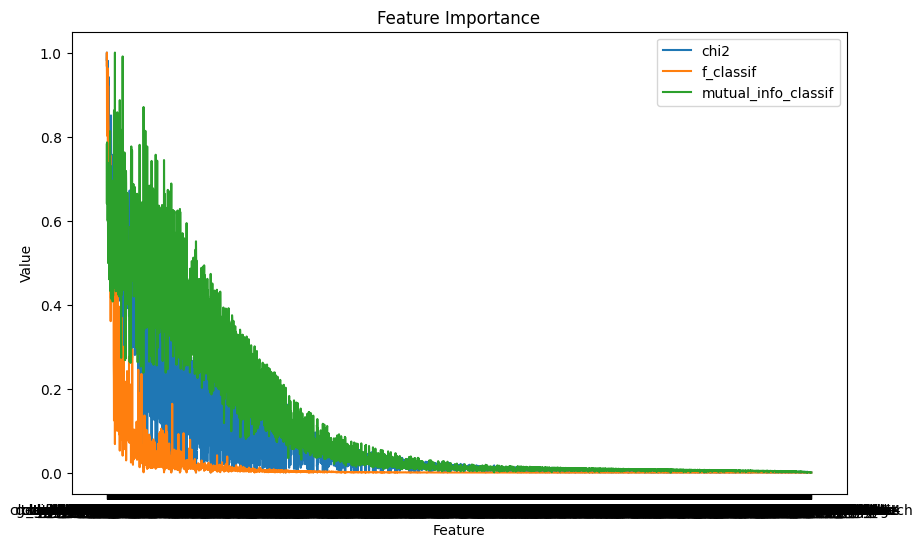

In [28]:
scores = feature_selection.calculate_scores(X, Y)
feature_selection.plot_single_scores(scores)

singles = singles.loc[scores["feature"].unique()]
singles = singles.reset_index()
feature_selection.plot_single_scores(singles)

# scores_robust = feature_selection.calculate_scores(X_ROBUST, Y_ROBUST)
# feature_selection.plot_single_scores(scores_robust)

2_ransomware
8_bdvl
9_xmrig
5_httpbackdoor
7_backdoor
6_beurk
1_normal
3_thetick
4_bashlite


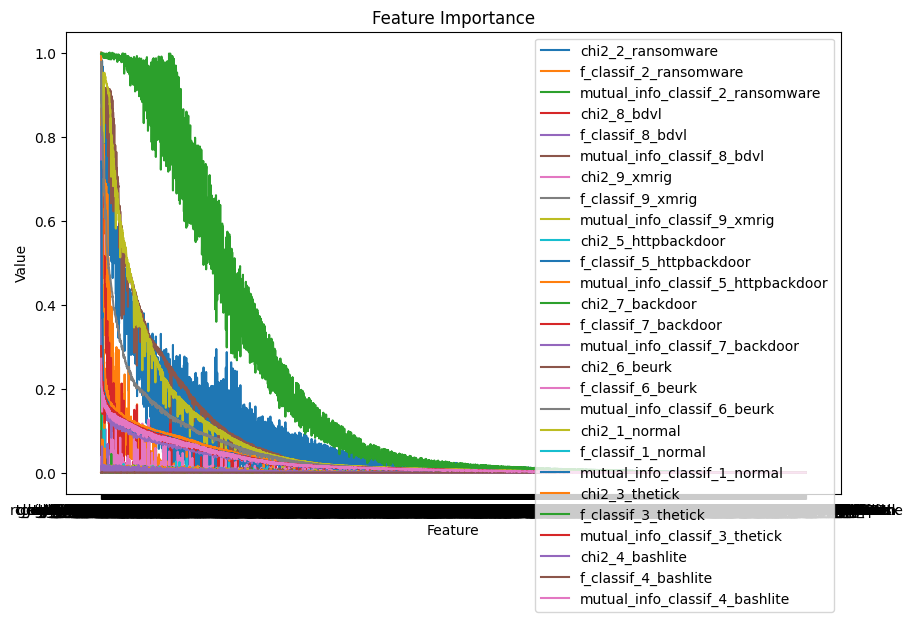

In [26]:
feature_selection.plot_scores_by_label_single_plot(scores_by_label)

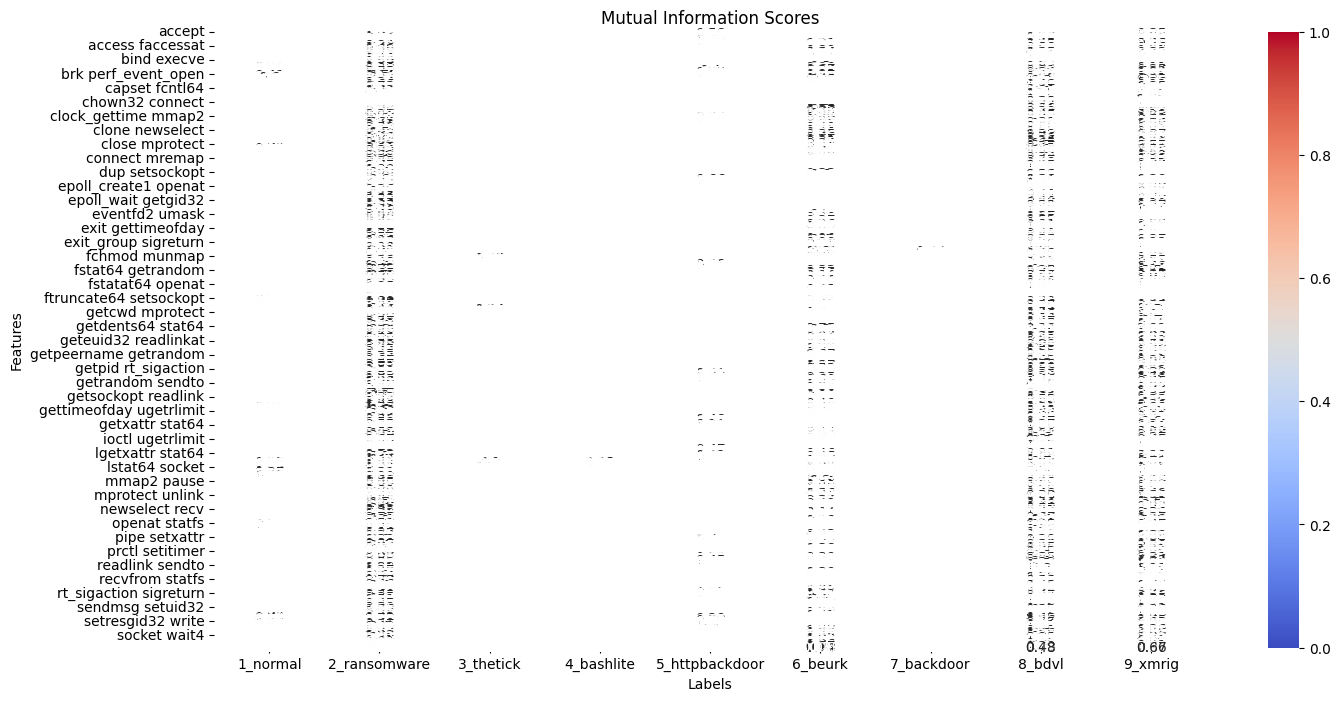

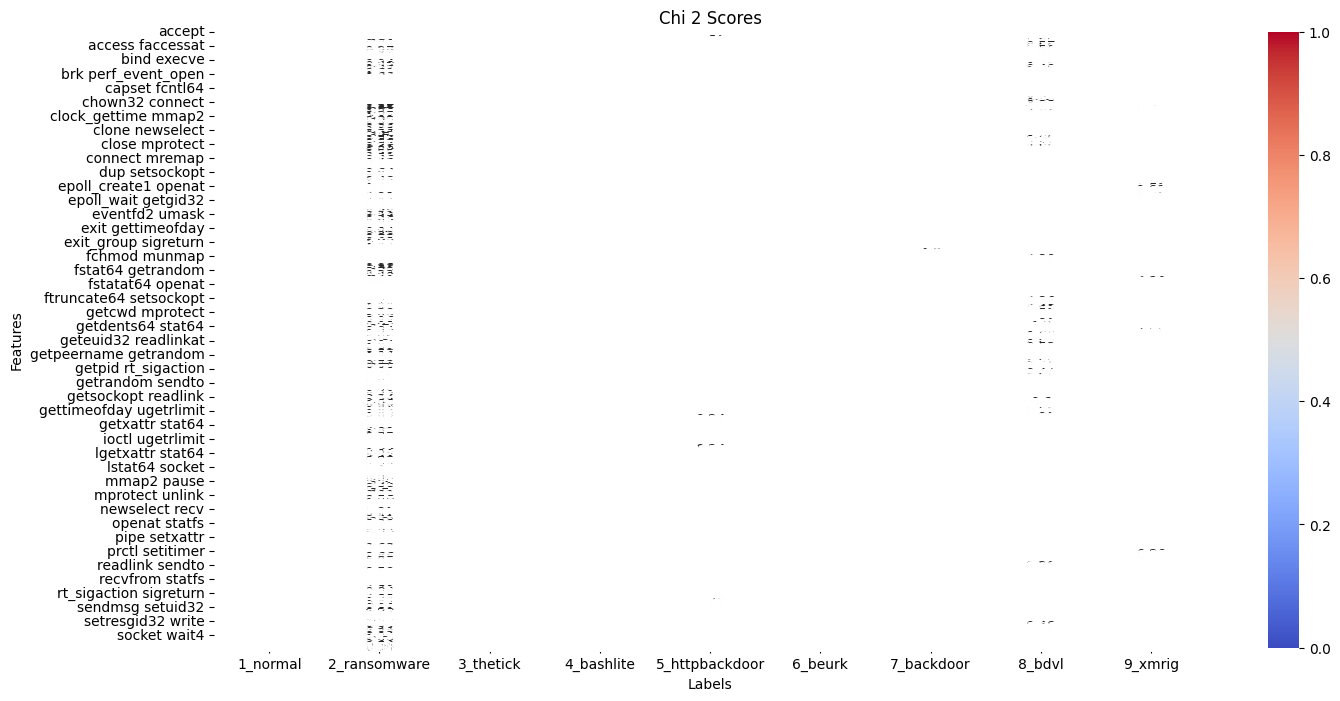

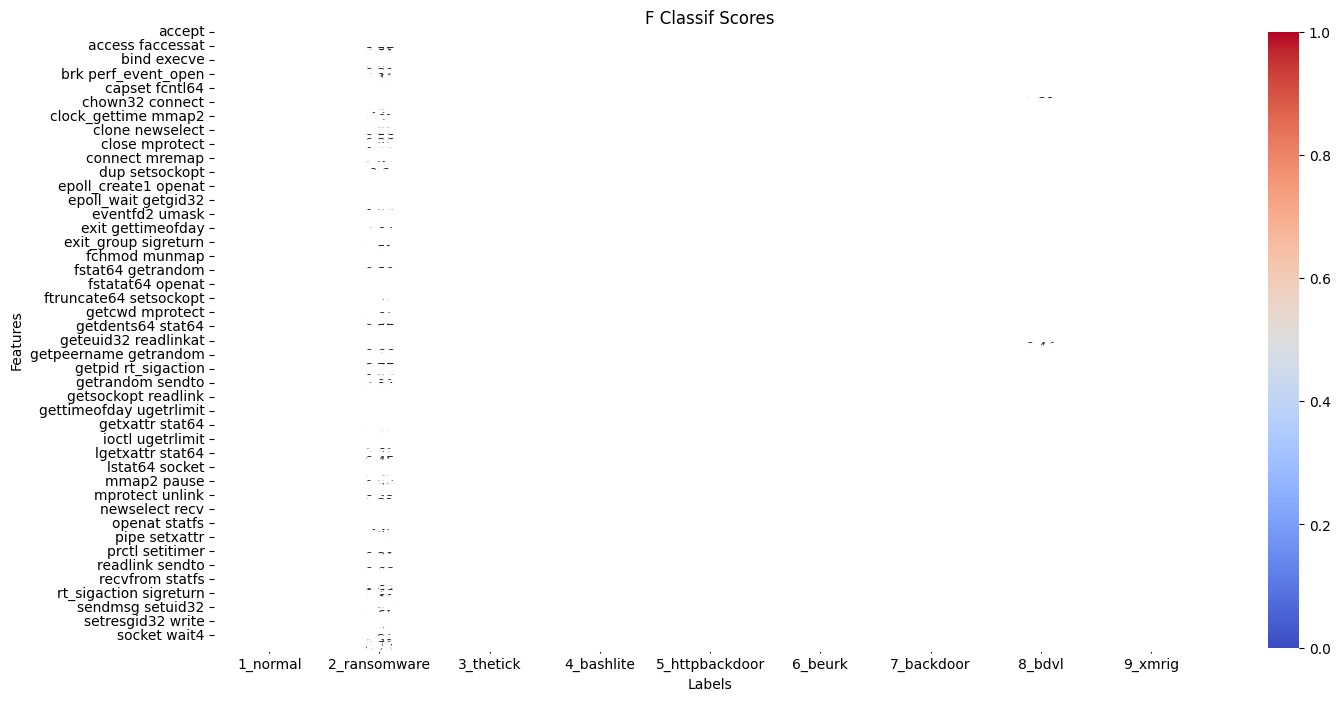

In [27]:
feature_selection.heatmap_scores_by_label_versus_features(scores_by_label)

In [ ]:
# scores_by_label_robust = feature_selection.calculate_scores_by_label(X_ROBUST, Y_ROBUST)
# feature_selection.heatmap_scores_by_label_versus_features(scores_by_label_robust)

In [ ]:
scores_by_label[""].unique()

#### Storing scores (modified for sys)

In [29]:
output_dir = repo_base_path / "feature_selection" / "result"
output_file_X = output_dir / f"{DATA_SOURCE}{VERSION}_{DEVICE_SOURCE}_featurescores.csv"
# output_file_X_ROBUST = output_dir / f"{DATA_SOURCE}{VERSION}_{DEVICE_SOURCE}_featurescores_ROBUST.csv"

In [30]:
scores_by_label.to_csv(output_file_X, index=False)
# scores_by_label_robust.to_csv(output_file_X_ROBUST, index=False)